In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import warnings
from math import sin, cos, sqrt, atan2, radians,asin
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
#import xgboost as xgb
from sklearn.metrics import roc_auc_score
#import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
warnings.filterwarnings('ignore')
import pickle
from sklearn.externals import joblib

In [17]:
train=pd.read_csv("all/train.csv",nrows=3000000)
print("Shape of Training Data",train.shape)
test=pd.read_csv("all/test.csv")
print("Shape of Testing Data", test.shape)



Shape of Training Data (3000000, 8)
Shape of Testing Data (9914, 7)


### Clean the data 
1. Remove fare amount < 0 
2. Passenger count > 7 remove from train data
3. Use only the fields that are present to create Baseline Model - have only date features. Rest of the features we will add later
4. Drop Locations outside New York

In [18]:
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]
def clean_data(data):
    boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}
    
    data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
    data['pickup_day']=data['pickup_datetime'].apply(lambda x:x.day)
    data['pickup_hour']=data['pickup_datetime'].apply(lambda x:x.hour)
    data['pickup_day_of_week']=data['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
    data['pickup_month']=data['pickup_datetime'].apply(lambda x:x.month)
    data['pickup_year']=data['pickup_datetime'].apply(lambda x:x.year)
    if 'fare_amount' in data.columns:
        data=data[data['fare_amount']>=0]
        data.loc[~((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
            (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
            (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
            (data.dropoff_latitude >=boundary['min_lat']) & (data.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1
        data.loc[((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
            (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
            (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
            (data.dropoff_latitude >=boundary['min_lat']) & (data.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

    #print("Outlier vs Non Outlier Counts")
    #print(data['is_outlier_loc'].value_counts())

    # Let us drop rows, where location is outlier
        data=data.loc[data['is_outlier_loc']==0]
        data.drop(['is_outlier_loc'],axis=1,inplace=True)
    
    data=data[data['passenger_count']<=8]
    data['pickup_day_of_week']=data['pickup_day_of_week'].apply(lambda x:encodeDays(x))
    return data

In [19]:
train=clean_data(train)
test=clean_data(test)
print("Shape of Training Data after cleaning ",train.shape)
print("Shape of Testing Data after cleaning", test.shape)

Shape of Training Data after cleaning  (2935680, 13)
Shape of Testing Data after cleaning (9914, 12)


### Create a function to process data for Modelling
This step includes:
1. Dropping unwanted columns from the data
2. One Hot Encoding of categorical variables
3. Dividing training data into train and validation data sets
    1. features and target varible must be seperated
    2. split ratio must be passed as an argument 

In [20]:
def processDataForModelling(data,target,drop_cols,is_train=True,split=0.25):
    data_1=data.drop(drop_cols,axis=1)
    # One hot Encoding
    data_1=pd.get_dummies(data_1)
    if is_train==True:
        X=data_1.drop([target],axis=1)
        y=data_1[target]
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=split,random_state=123)
        
        print("Shape of Training Features",X_train.shape)
        print("Shape of Validation Features ",X_test.shape)
        
        return X_train, X_test, y_train, y_test
    else:
        print ("Shape of Test Data",data_1.shape)
        return data_1
    

In [21]:
X_train, X_test, y_train, y_test=processDataForModelling(train,'fare_amount',drop_cols=['key','pickup_datetime'],is_train=True,split=0.2)

Shape of Training Features (2348544, 10)
Shape of Validation Features  (587136, 10)


In [22]:
test_data=processDataForModelling(test,'fare_amount',drop_cols=['key','pickup_datetime'],is_train=False)

Shape of Test Data (9914, 10)


### Building a Baseline Model and Identifying a good ML algorithm for this problem
The metric used in this problem is RMSE. 
We will try three models - Linear Regression, Random Forest and XGBoost and see which model performs better.
We will use the best model among the three to further tune and apply feature Engineering

For Baseline, we will predict the average fare amount and check the RMSE on validation data. Any model, should be able to beat this simple benchmark

In [8]:
avg_fare=round(np.mean(y_train),2)
avg_fare

11.31

In [9]:
baseline_pred=np.repeat(avg_fare,y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))
print("Basline RMSE of Validation data :",baseline_rmse)

Basline RMSE of Validation data : 9.611176143919515


##### Build a Linear Regression Model 

In [26]:
lm = LinearRegression()
lm.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

The linear regression model performed better than than the Baseline Mode. Let us create a Random Forest Model and see how it performs. Reason for failure of logistic regression model, is that it tries to fit a linear line between the variables and the targer. But, as we saw in the Exploratory analysis phase this is not true. Linear Regression Models will have high bias and low variance. 

In [14]:
pickle.dump(lm, open("models_3M/LR.sav", 'wb'))

In [27]:
lm=pickle.load(open('models_3M/LR.sav', 'rb'))

In [28]:
y_pred=np.round(lm.predict(X_test),2)


lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  8.14028848424604


##### Build a Random Forest Model 

In [18]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 883,n_jobs=-1)
rf.fit(X_train,y_train)


OSError: [Errno 22] Invalid argument

In [ ]:
rf

In [29]:
joblib.dump(rf,"models_3M/randomforest.sav")

['models_3M/randomforest.sav']

In [29]:
rf=joblib.load('models_3M/randomforest.sav')
rf_pred= rf.predict(X_test)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
print("RMSE for Random Forest is ",rf_rmse)

RMSE for Random Forest is  3.722760643979709


Random Forest has reduced the RMSE considerably as compared to Linear Regression. Random Forest works on the principle of Bagging
The idea behind this is very intutive- when we want to make a decision about a field we do not know about we take advice from a people and then we decide based on the majority opinion.
This is the idea behind Random Forest - multiple decision trees are created and output from each of the trees are averaged to predict the value.
Random Forest are not susceptible to overfitting and since in Random Forest, each tree is trained independently of the other, it is more robust.

The next type of algorithm we will see is also another Tree based Ensemble algorithm - but it follows concept of Boosting. 




#### Building LightGBM Algorithm

In [30]:
train_data=lgb.Dataset(X_train,label=y_train)


In [32]:
param = {'num_leaves':31, 'num_trees':5000, 'objective':'regression'}
param['metric'] = 'l2_root'

In [33]:
num_round=2500
cv_results = lgb.cv(param, train_data, num_boost_round=num_round, nfold=10,verbose_eval=20, early_stopping_rounds=20,stratified=False)

[20]	cv_agg's rmse: 5.06937 + 0.0937088
[40]	cv_agg's rmse: 4.51336 + 0.10132
[60]	cv_agg's rmse: 4.31256 + 0.0979842
[80]	cv_agg's rmse: 4.22526 + 0.0978898
[100]	cv_agg's rmse: 4.16198 + 0.0975422
[120]	cv_agg's rmse: 4.11534 + 0.100577
[140]	cv_agg's rmse: 4.08472 + 0.0993362
[160]	cv_agg's rmse: 4.06033 + 0.100064
[180]	cv_agg's rmse: 4.03975 + 0.101011
[200]	cv_agg's rmse: 4.02197 + 0.100109
[220]	cv_agg's rmse: 4.00684 + 0.102158
[240]	cv_agg's rmse: 3.99238 + 0.103733
[260]	cv_agg's rmse: 3.98044 + 0.102612
[280]	cv_agg's rmse: 3.97015 + 0.100662
[300]	cv_agg's rmse: 3.9603 + 0.100332
[320]	cv_agg's rmse: 3.95286 + 0.099647
[340]	cv_agg's rmse: 3.94603 + 0.100222
[360]	cv_agg's rmse: 3.93663 + 0.0989949
[380]	cv_agg's rmse: 3.93024 + 0.0996305
[400]	cv_agg's rmse: 3.92465 + 0.100501
[420]	cv_agg's rmse: 3.91913 + 0.100063
[440]	cv_agg's rmse: 3.9146 + 0.0998755
[460]	cv_agg's rmse: 3.91079 + 0.100746
[480]	cv_agg's rmse: 3.9063 + 0.100846
[500]	cv_agg's rmse: 3.9024 + 0.100475
[

In [34]:
print('Best num_boost_round:', len(cv_results['rmse-mean']))
#lgb_pred = lgb_bst.predict(X_test)

Best num_boost_round: 2482


In [35]:
lgb_bst=lgb.train(param,train_data,len(cv_results['rmse-mean']))
joblib.dump(lgb_bst, "models_3M/lgbm_with_no_featureEngineering.sav")

['models_3M/lgbm_with_no_featureEngineering.sav']

In [31]:
lgb_bst=joblib.load('models_3M/lgbm_with_no_featureEngineering.sav')


lgb_pred = lgb_bst.predict(X_test)
lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, y_test))
print("RMSE for Light GBM is ",lgb_rmse)

RMSE for Light GBM is  3.7930303182358633


Random Forest  RMSE is better than Light GBM

### For each of the model we have built above, let us see what is the train RMSE and test RMSE - This will help us understand variance in the model and get the best model

In [32]:
model_pred=pd.DataFrame()
model_pred['model_name']=['Linear Regression','Random Forest','Light GBM']
model_pred['test_rmse']=[lm_rmse,rf_rmse,lgb_rmse]

In [ ]:
lm_train_rmse=np.sqrt(mean_squared_error(lm.predict(X_train), y_train))
rf_train_rmse=np.sqrt(mean_squared_error(rf.predict(X_train),y_train))
lgb_train_rmse=np.sqrt(mean_squared_error(lgb_bst.predict(X_train),y_train))

model_pred['train_rmse']=[lm_train_rmse,rf_train_rmse,lgb_train_rmse]

In [ ]:
model_pred['variance']=model_pred['train_rmse'] - model_pred['test_rmse']
model_pred

We can see that there is a very high difference in the train and test RMSE for Random Forest, though overall the test-rmse of Random Forest is the best. Very high variance is a sign of overfitting. 
XGBOOST has done slighlty better than Light GBM in terms of training and test rmse - but variance is higher in XGBOOST
In further work, we will consider LightGBM as the model and add features and tune this model. 

#### Feature Engineering

In [ ]:
nyc_airports={'JFK':{'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659},
              
    'EWR':{'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        },
    'LaGuardia':{'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
        
    }
    
}
def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0

In [ ]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },
    
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007

    },

    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395

    },

    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176

    },

    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490

    }
}


def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0

In [ ]:

X_train['is_pickup_la_guardia']=X_train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
X_train['is_dropoff_la_guardia']=X_train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)
X_train['is_pickup_EWR']=X_train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
X_train['is_dropoff_EWR']=X_train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
X_train['is_pickup_JFK']=X_train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
X_train['is_dropoff_JFK']=X_train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)




X_test['is_pickup_la_guardia']=X_test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
X_test['is_dropoff_la_guardia']=X_test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)
X_test['is_pickup_EWR']=X_test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
X_test['is_dropoff_EWR']=X_test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
X_test['is_pickup_JFK']=X_test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
X_test['is_dropoff_JFK']=X_test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)


test['is_pickup_la_guardia']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
test['is_dropoff_la_guardia']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)
test['is_pickup_EWR']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
test['is_dropoff_EWR']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
test['is_pickup_JFK']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
test['is_dropoff_JFK']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)



In [ ]:
def getBorough(lat,lng):
    
    locs=nyc_boroughs.keys()
    for loc in locs:
        if lat>=nyc_boroughs[loc]['min_lat'] and lat<=nyc_boroughs[loc]['max_lat'] and lng>=nyc_boroughs[loc]['min_lng'] and lng<=nyc_boroughs[loc]['max_lng']:
            return loc
    return 'others'
X_train['pickup_borough']=X_train.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
X_train['dropoff_borough']=X_train.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
X_test['pickup_borough']=X_test.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
X_test['dropoff_borough']=X_test.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

test['pickup_borough']=test.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
test['dropoff_borough']=test.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

X_train=pd.get_dummies(X_train)
X_test=pd.get_dummies(X_test)
test=pd.get_dummies(test)

In [ ]:
lower_manhattan_boundary={'min_lng': -74.0194,
                          'min_lat':40.6997,
                          'max_lng':-73.9716,
                          'max_lat':40.7427}

def isLowerManhattan(lat,lng):
    if lat>=lower_manhattan_boundary['min_lat'] and lat<=lower_manhattan_boundary['max_lat'] and lng>=lower_manhattan_boundary['min_lng'] and lng<=lower_manhattan_boundary['max_lng']:
        return 1
    else:
        return 0

In [ ]:
X_train['is_pickup_lower_manhattan']=X_train.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
X_train['is_dropoff_lower_manhattan']=X_train.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [ ]:
X_test['is_pickup_lower_manhattan']=X_test.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
X_test['is_dropoff_lower_manhattan']=X_test.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

test['is_pickup_lower_manhattan']=test.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
test['is_dropoff_lower_manhattan']=test.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)


In [ ]:
def distance(lat1,lon1,lat2,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))
#X_train['trip_distance']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)
#X_test['trip_distance']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

#test['trip_distance']=test.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

lgr=(-73.8733, 40.7746)
jfk=(-73.7900, 40.6437)
ewr=(-74.1843, 40.6924)

test['pickup_distance_jfk']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],jfk[1],jfk[0]),axis=1)
test['dropoff_distance_jfk']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],jfk[1],jfk[0]),axis=1)
test['pickup_distance_ewr']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],ewr[1],ewr[0]),axis=1)
test['dropoff_distance_ewr']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],ewr[1],ewr[0]),axis=1)
test['pickup_distance_laguardia']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],lgr[1],lgr[0]),axis=1)
test['dropoff_distance_laguardia']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],lgr[1],lgr[0]),axis=1)

X_train['pickup_distance_jfk']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],jfk[1],jfk[0]),axis=1)
X_train['dropoff_distance_jfk']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],jfk[1],jfk[0]),axis=1)
X_train['pickup_distance_ewr']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],ewr[1],ewr[0]),axis=1)
X_train['dropoff_distance_ewr']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],ewr[1],ewr[0]),axis=1)
X_train['pickup_distance_laguardia']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],lgr[1],lgr[0]),axis=1)
X_train['dropoff_distance_laguardia']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],lgr[1],lgr[0]),axis=1)

X_test['pickup_distance_jfk']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],jfk[1],jfk[0]),axis=1)
X_test['dropoff_distance_jfk']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],jfk[1],jfk[0]),axis=1)
X_test['pickup_distance_ewr']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],ewr[1],ewr[0]),axis=1)
X_test['dropoff_distance_ewr']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],ewr[1],ewr[0]),axis=1)
X_test['pickup_distance_laguardia']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],lgr[1],lgr[0]),axis=1)
X_test['dropoff_distance_laguardia']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],lgr[1],lgr[0]),axis=1)

In [ ]:
manhattan=(-73.9664, 40.7909)
queens=(-73.8317, 40.7038)
brooklyn=(-73.9489, 40.6551)
bronx=(-73.8568, 40.8572)
staten_island=(-74.1540, 40.5725)




test['pickup_distance_manhattan']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],manhattan[1],manhattan[0]),axis=1)
test['pickup_distance_queens']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],queens[1],queens[0]),axis=1)
test['pickup_distance_brooklyn']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],brooklyn[1],brooklyn[0]),axis=1)
test['pickup_distance_bronx']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],bronx[1],bronx[0]),axis=1)
test['pickup_distance_statenisland']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],staten_island[1],staten_island[0]),axis=1)





test['dropoff_distance_manhattan']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],manhattan[1],manhattan[0]),axis=1)
test['dropoff_distance_queens']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],queens[1],queens[0]),axis=1)
test['dropoff_distance_brooklyn']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],brooklyn[1],brooklyn[0]),axis=1)
test['dropoff_distance_bronx']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],bronx[1],bronx[0]),axis=1)
test['dropoff_distance_statenisland']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],staten_island[1],staten_island[0]),axis=1)


X_train['pickup_distance_manhattan']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],manhattan[1],manhattan[0]),axis=1)
X_train['pickup_distance_queens']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],queens[1],queens[0]),axis=1)
X_train['pickup_distance_brooklyn']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],brooklyn[1],brooklyn[0]),axis=1)
X_train['pickup_distance_bronx']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],bronx[1],bronx[0]),axis=1)
X_train['pickup_distance_statenisland']=X_train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],staten_island[1],staten_island[0]),axis=1)

X_train['dropoff_distance_manhattan']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],manhattan[1],manhattan[0]),axis=1)
X_train['dropoff_distance_queens']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],queens[1],queens[0]),axis=1)
X_train['dropoff_distance_brooklyn']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],brooklyn[1],brooklyn[0]),axis=1)
X_train['dropoff_distance_bronx']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],bronx[1],bronx[0]),axis=1)
X_train['dropoff_distance_statenisland']=X_train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],staten_island[1],staten_island[0]),axis=1)




X_test['pickup_distance_manhattan']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],manhattan[1],manhattan[0]),axis=1)
X_test['pickup_distance_queens']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],queens[1],queens[0]),axis=1)
X_test['pickup_distance_brooklyn']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],brooklyn[1],brooklyn[0]),axis=1)
X_test['pickup_distance_bronx']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],bronx[1],bronx[0]),axis=1)
X_test['pickup_distance_statenisland']=X_test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],staten_island[1],staten_island[0]),axis=1)

X_test['dropoff_distance_manhattan']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],manhattan[1],manhattan[0]),axis=1)
X_test['dropoff_distance_queens']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],queens[1],queens[0]),axis=1)
X_test['dropoff_distance_brooklyn']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],brooklyn[1],brooklyn[0]),axis=1)
X_test['dropoff_distance_bronx']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],bronx[1],bronx[0]),axis=1)
X_test['dropoff_distance_statenisland']=X_test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],staten_island[1],staten_island[0]),axis=1)




In [ ]:
X_train.to_csv("X_train_cleaned.csv",index=False)
X_test.to_csv("X_test_cleaned.csv",index=False)
test.to_csv("test_cleaned.csv",index=False)

In [34]:
X_train=pd.read_csv("X_train_cleaned.csv")
X_test=pd.read_csv("X_test_cleaned.csv")
test=pd.read_csv("test_cleaned.csv")

In [35]:
train_data=lgb.Dataset(X_train,label=y_train)
param = {'num_leaves':31, 'num_trees':2500, 'objective':'regression'}
param['metric'] = 'l2_root'

In [36]:
num_round=2500
cv_results = lgb.cv(param, train_data, num_boost_round=num_round, nfold=5,verbose_eval=20, early_stopping_rounds=20,stratified=False)

[20]	cv_agg's rmse: 4.91025 + 0.0504822
[40]	cv_agg's rmse: 4.35817 + 0.0454184
[60]	cv_agg's rmse: 4.15816 + 0.0507386
[80]	cv_agg's rmse: 4.0568 + 0.0527038
[100]	cv_agg's rmse: 3.9873 + 0.0480733
[120]	cv_agg's rmse: 3.93842 + 0.0479773
[140]	cv_agg's rmse: 3.9058 + 0.0495644
[160]	cv_agg's rmse: 3.87876 + 0.0487566
[180]	cv_agg's rmse: 3.86091 + 0.0471493
[200]	cv_agg's rmse: 3.84435 + 0.0485448
[220]	cv_agg's rmse: 3.83164 + 0.0482393
[240]	cv_agg's rmse: 3.81989 + 0.0478475
[260]	cv_agg's rmse: 3.81117 + 0.0480299
[280]	cv_agg's rmse: 3.80197 + 0.0481522
[300]	cv_agg's rmse: 3.79462 + 0.0470023
[320]	cv_agg's rmse: 3.78858 + 0.0473937
[340]	cv_agg's rmse: 3.78213 + 0.0478054
[360]	cv_agg's rmse: 3.7749 + 0.046803
[380]	cv_agg's rmse: 3.77065 + 0.0466102
[400]	cv_agg's rmse: 3.76573 + 0.0483255
[420]	cv_agg's rmse: 3.76161 + 0.0484686
[440]	cv_agg's rmse: 3.75723 + 0.0483547
[460]	cv_agg's rmse: 3.75291 + 0.0484905
[480]	cv_agg's rmse: 3.74843 + 0.0479367
[500]	cv_agg's rmse: 3.74

In [37]:
print('Best num_boost_round:', len(cv_results['rmse-mean']))

Best num_boost_round: 2495


In [38]:
lgb_bst=lgb.train(param,train_data,len(cv_results['rmse-mean']))

In [39]:
joblib.dump(lgb_bst,"models_3M/lgbm_featureEngineering_notuning.sav")

['models_3M/lgbm_featureEngineering_notuning.sav']

In [40]:
lgb_bst=joblib.load('models_3M/lgbm_featureEngineering_notuning.sav')


lgb_pred = lgb_bst.predict(X_test)
lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, y_test))
print("RMSE for Light GBM with Feature Engineering is ",lgb_rmse)

RMSE for Light GBM with Feature Engineering is  3.6421474436154613


In [ ]:
lgb_train_rmse=np.sqrt(mean_squared_error(lgb_bst.predict(X_train),y_train))
print("Train RMSE for Light GBM with Feature Engineering is", lgb_train_rmse)

In [ ]:
variance=lgb_train_rmse - lgb_rmse
print("Variance of Light GBM with Feature Engineering is ", variance)

With Feature Engineering, the RMSE has decreased from 3.78 to 3.64. The variance of the model has also come down from 0.5 to 0.48. Let us tune Light GBM Model

### Tuning Light GBM

1. max_depth - this parameter is used to handle overfitting. If model overfits - reduce this value
2. min_data_in_leaf - this is the minimum number of records in each leaf - increase this value to reduce overfitting
3. learning rate - impact of each tree on the final outcome - smaller learning rate with more iterations increases the accuracy
4. num_leaves - this is the main factor that effects the model. 
5. Baggin_fraction - specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting
6.feature_fraction - specifies fraction of features to be used in each iteration


### Let us XGB Regressor using Hyperopt and get the best params

In [ ]:
X_train=pd.read_csv("X_train_cleaned.csv")
X_test=pd.read_csv("X_test_cleaned.csv")
#y_train=pd.read_csv("Y_Train.csv")
#y_test=pd.read_csv("Y_test.csv")

In [ ]:
def objective(space):

    clf = lgb.LGBMRegressor(
          objective = 'regression',
          n_jobs = -1, # Updated from 'nthread'
          verbose=1,
          boosting_type='gbdt',
        num_leaves=60,
        bagging_freq=20,
       subsample_freq=100,
    max_depth=int(space['max_depth']),
    subsample=space['subsample'],
        n_estimators=5000,
    colsample_bytree=space['colsample'])
          #metric='l2_root')

    eval_set=[( X_train, y_train), ( X_test,y_test)]

    clf.fit(X_train, np.array(y_train),
            eval_set=eval_set,eval_metric='rmse',
            early_stopping_rounds=20)

    pred = clf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print("SCORE:", rmse)

    return{'loss':rmse, 'status': STATUS_OK }



In [ ]:
space ={
        'max_depth': hp.quniform("x_max_depth", 5, 30, 3),
        #'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'colsample':hp.uniform ('x_colsample', 0.3, 1)
    }

In [ ]:
from hyperopt.mongoexp import MongoTrials
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

In [41]:
best={'x_max_depth': 24.0, 'x_subsample': 0.9988461076307639, 'x_colsample': 0.38429620148564814}


In [42]:

clf = lgb.LGBMRegressor(
          objective = 'regression',
          n_jobs = -1, # Updated from 'nthread'
          verbose=1,
          boosting_type='gbdt',
        num_leaves=60,
        bagging_freq=20,
       subsample_freq=100,
    max_depth=int(best['x_max_depth']),
    subsample=best['x_subsample'],
        n_estimators=5000,
    colsample_bytree=best['x_colsample'])
          #metric='l2_root')

In [43]:
eval_set=[( X_train, y_train), ( X_test,y_test)]
clf.fit(X_train, np.array(y_train),eval_set=eval_set,eval_metric='rmse',early_stopping_rounds=20)

[1]	valid_0's l2: 80.6369	valid_0's rmse: 8.9798	valid_1's l2: 79.9082	valid_1's rmse: 8.93914
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l2: 70.4463	valid_0's rmse: 8.39323	valid_1's l2: 69.7903	valid_1's rmse: 8.35406
[3]	valid_0's l2: 61.7557	valid_0's rmse: 7.85848	valid_1's l2: 61.1582	valid_1's rmse: 7.82037
[4]	valid_0's l2: 54.6131	valid_0's rmse: 7.39007	valid_1's l2: 54.0724	valid_1's rmse: 7.35339
[5]	valid_0's l2: 48.9213	valid_0's rmse: 6.99438	valid_1's l2: 48.4314	valid_1's rmse: 6.95927
[6]	valid_0's l2: 44.2635	valid_0's rmse: 6.65308	valid_1's l2: 43.8174	valid_1's rmse: 6.61947
[7]	valid_0's l2: 40.5784	valid_0's rmse: 6.37012	valid_1's l2: 40.1748	valid_1's rmse: 6.33836
[8]	valid_0's l2: 37.3938	valid_0's rmse: 6.11505	valid_1's l2: 37.0172	valid_1's rmse: 6.08418
[9]	valid_0's l2: 34.4907	valid_0's rmse: 5.87288	valid_1's l2: 34.1438	valid_1's rmse: 5.84327
[10]	valid_0's l2: 32.1029	valid_0's rmse: 5.66594	valid_1's l2: 31.7796	va

[86]	valid_0's l2: 14.7836	valid_0's rmse: 3.84494	valid_1's l2: 15.0312	valid_1's rmse: 3.87701
[87]	valid_0's l2: 14.7469	valid_0's rmse: 3.84017	valid_1's l2: 15	valid_1's rmse: 3.87298
[88]	valid_0's l2: 14.7122	valid_0's rmse: 3.83564	valid_1's l2: 14.9685	valid_1's rmse: 3.86891
[89]	valid_0's l2: 14.6943	valid_0's rmse: 3.83331	valid_1's l2: 14.9569	valid_1's rmse: 3.86742
[90]	valid_0's l2: 14.6741	valid_0's rmse: 3.83068	valid_1's l2: 14.9441	valid_1's rmse: 3.86576
[91]	valid_0's l2: 14.6525	valid_0's rmse: 3.82786	valid_1's l2: 14.9336	valid_1's rmse: 3.8644
[92]	valid_0's l2: 14.6298	valid_0's rmse: 3.82489	valid_1's l2: 14.9138	valid_1's rmse: 3.86184
[93]	valid_0's l2: 14.6009	valid_0's rmse: 3.82112	valid_1's l2: 14.8873	valid_1's rmse: 3.8584
[94]	valid_0's l2: 14.5609	valid_0's rmse: 3.81587	valid_1's l2: 14.851	valid_1's rmse: 3.8537
[95]	valid_0's l2: 14.5446	valid_0's rmse: 3.81374	valid_1's l2: 14.8421	valid_1's rmse: 3.85254
[96]	valid_0's l2: 14.5077	valid_0's rm

[171]	valid_0's l2: 13.3574	valid_0's rmse: 3.65478	valid_1's l2: 14.0942	valid_1's rmse: 3.75423
[172]	valid_0's l2: 13.3472	valid_0's rmse: 3.65338	valid_1's l2: 14.0866	valid_1's rmse: 3.75321
[173]	valid_0's l2: 13.3368	valid_0's rmse: 3.65196	valid_1's l2: 14.0847	valid_1's rmse: 3.75295
[174]	valid_0's l2: 13.3249	valid_0's rmse: 3.65033	valid_1's l2: 14.0877	valid_1's rmse: 3.75336
[175]	valid_0's l2: 13.3135	valid_0's rmse: 3.64877	valid_1's l2: 14.085	valid_1's rmse: 3.753
[176]	valid_0's l2: 13.3055	valid_0's rmse: 3.64767	valid_1's l2: 14.0805	valid_1's rmse: 3.75239
[177]	valid_0's l2: 13.2962	valid_0's rmse: 3.64639	valid_1's l2: 14.0737	valid_1's rmse: 3.75149
[178]	valid_0's l2: 13.2839	valid_0's rmse: 3.64471	valid_1's l2: 14.0642	valid_1's rmse: 3.75022
[179]	valid_0's l2: 13.2766	valid_0's rmse: 3.64371	valid_1's l2: 14.0587	valid_1's rmse: 3.7495
[180]	valid_0's l2: 13.2667	valid_0's rmse: 3.64235	valid_1's l2: 14.0543	valid_1's rmse: 3.74891
[181]	valid_0's l2: 13.2

[255]	valid_0's l2: 12.6983	valid_0's rmse: 3.56347	valid_1's l2: 13.8086	valid_1's rmse: 3.71599
[256]	valid_0's l2: 12.6897	valid_0's rmse: 3.56227	valid_1's l2: 13.8053	valid_1's rmse: 3.71555
[257]	valid_0's l2: 12.6839	valid_0's rmse: 3.56144	valid_1's l2: 13.8008	valid_1's rmse: 3.71494
[258]	valid_0's l2: 12.6782	valid_0's rmse: 3.56065	valid_1's l2: 13.8008	valid_1's rmse: 3.71494
[259]	valid_0's l2: 12.6732	valid_0's rmse: 3.55994	valid_1's l2: 13.7982	valid_1's rmse: 3.71459
[260]	valid_0's l2: 12.6667	valid_0's rmse: 3.55903	valid_1's l2: 13.8016	valid_1's rmse: 3.71504
[261]	valid_0's l2: 12.6603	valid_0's rmse: 3.55813	valid_1's l2: 13.7992	valid_1's rmse: 3.71472
[262]	valid_0's l2: 12.654	valid_0's rmse: 3.55725	valid_1's l2: 13.7984	valid_1's rmse: 3.71462
[263]	valid_0's l2: 12.6486	valid_0's rmse: 3.55648	valid_1's l2: 13.7957	valid_1's rmse: 3.71425
[264]	valid_0's l2: 12.641	valid_0's rmse: 3.55542	valid_1's l2: 13.7916	valid_1's rmse: 3.71371
[265]	valid_0's l2: 12

[339]	valid_0's l2: 12.2395	valid_0's rmse: 3.4985	valid_1's l2: 13.6165	valid_1's rmse: 3.69005
[340]	valid_0's l2: 12.232	valid_0's rmse: 3.49743	valid_1's l2: 13.614	valid_1's rmse: 3.68971
[341]	valid_0's l2: 12.2282	valid_0's rmse: 3.49688	valid_1's l2: 13.6131	valid_1's rmse: 3.6896
[342]	valid_0's l2: 12.2243	valid_0's rmse: 3.49632	valid_1's l2: 13.6115	valid_1's rmse: 3.68938
[343]	valid_0's l2: 12.218	valid_0's rmse: 3.49542	valid_1's l2: 13.611	valid_1's rmse: 3.68931
[344]	valid_0's l2: 12.2134	valid_0's rmse: 3.49477	valid_1's l2: 13.6092	valid_1's rmse: 3.68906
[345]	valid_0's l2: 12.2107	valid_0's rmse: 3.49438	valid_1's l2: 13.6087	valid_1's rmse: 3.689
[346]	valid_0's l2: 12.207	valid_0's rmse: 3.49385	valid_1's l2: 13.6095	valid_1's rmse: 3.6891
[347]	valid_0's l2: 12.2007	valid_0's rmse: 3.49295	valid_1's l2: 13.6101	valid_1's rmse: 3.68919
[348]	valid_0's l2: 12.1977	valid_0's rmse: 3.49252	valid_1's l2: 13.6084	valid_1's rmse: 3.68896
[349]	valid_0's l2: 12.1946	va

[424]	valid_0's l2: 11.9081	valid_0's rmse: 3.45082	valid_1's l2: 13.5358	valid_1's rmse: 3.6791
[425]	valid_0's l2: 11.9048	valid_0's rmse: 3.45034	valid_1's l2: 13.5348	valid_1's rmse: 3.67896
[426]	valid_0's l2: 11.9012	valid_0's rmse: 3.44981	valid_1's l2: 13.5343	valid_1's rmse: 3.6789
[427]	valid_0's l2: 11.8976	valid_0's rmse: 3.44928	valid_1's l2: 13.5326	valid_1's rmse: 3.67867
[428]	valid_0's l2: 11.8944	valid_0's rmse: 3.44883	valid_1's l2: 13.5319	valid_1's rmse: 3.67857
[429]	valid_0's l2: 11.8915	valid_0's rmse: 3.4484	valid_1's l2: 13.5323	valid_1's rmse: 3.67863
[430]	valid_0's l2: 11.8876	valid_0's rmse: 3.44784	valid_1's l2: 13.5311	valid_1's rmse: 3.67847
[431]	valid_0's l2: 11.8847	valid_0's rmse: 3.44741	valid_1's l2: 13.5303	valid_1's rmse: 3.67835
[432]	valid_0's l2: 11.878	valid_0's rmse: 3.44645	valid_1's l2: 13.5258	valid_1's rmse: 3.67775
[433]	valid_0's l2: 11.8751	valid_0's rmse: 3.44602	valid_1's l2: 13.5244	valid_1's rmse: 3.67755
[434]	valid_0's l2: 11.8

[508]	valid_0's l2: 11.6177	valid_0's rmse: 3.40848	valid_1's l2: 13.4662	valid_1's rmse: 3.66963
[509]	valid_0's l2: 11.6153	valid_0's rmse: 3.40812	valid_1's l2: 13.4673	valid_1's rmse: 3.66978
[510]	valid_0's l2: 11.6126	valid_0's rmse: 3.40772	valid_1's l2: 13.4667	valid_1's rmse: 3.6697
[511]	valid_0's l2: 11.6103	valid_0's rmse: 3.40739	valid_1's l2: 13.466	valid_1's rmse: 3.66961
[512]	valid_0's l2: 11.6095	valid_0's rmse: 3.40727	valid_1's l2: 13.4659	valid_1's rmse: 3.6696
[513]	valid_0's l2: 11.6072	valid_0's rmse: 3.40693	valid_1's l2: 13.4657	valid_1's rmse: 3.66956
[514]	valid_0's l2: 11.6049	valid_0's rmse: 3.40659	valid_1's l2: 13.4658	valid_1's rmse: 3.66958
[515]	valid_0's l2: 11.6023	valid_0's rmse: 3.40621	valid_1's l2: 13.4657	valid_1's rmse: 3.66956
[516]	valid_0's l2: 11.5985	valid_0's rmse: 3.40566	valid_1's l2: 13.4645	valid_1's rmse: 3.6694
[517]	valid_0's l2: 11.5967	valid_0's rmse: 3.40539	valid_1's l2: 13.4646	valid_1's rmse: 3.66942
[518]	valid_0's l2: 11.5

[593]	valid_0's l2: 11.3594	valid_0's rmse: 3.37037	valid_1's l2: 13.426	valid_1's rmse: 3.66415
[594]	valid_0's l2: 11.3566	valid_0's rmse: 3.36996	valid_1's l2: 13.4247	valid_1's rmse: 3.66397
[595]	valid_0's l2: 11.3537	valid_0's rmse: 3.36952	valid_1's l2: 13.4248	valid_1's rmse: 3.66399
[596]	valid_0's l2: 11.3505	valid_0's rmse: 3.36905	valid_1's l2: 13.4234	valid_1's rmse: 3.6638
[597]	valid_0's l2: 11.346	valid_0's rmse: 3.36839	valid_1's l2: 13.4211	valid_1's rmse: 3.66349
[598]	valid_0's l2: 11.3438	valid_0's rmse: 3.36805	valid_1's l2: 13.4216	valid_1's rmse: 3.66356
[599]	valid_0's l2: 11.3427	valid_0's rmse: 3.36789	valid_1's l2: 13.4216	valid_1's rmse: 3.66356
[600]	valid_0's l2: 11.3406	valid_0's rmse: 3.36758	valid_1's l2: 13.4216	valid_1's rmse: 3.66356
[601]	valid_0's l2: 11.3389	valid_0's rmse: 3.36733	valid_1's l2: 13.4211	valid_1's rmse: 3.66348
[602]	valid_0's l2: 11.3371	valid_0's rmse: 3.36706	valid_1's l2: 13.4212	valid_1's rmse: 3.6635
[603]	valid_0's l2: 11.3

[679]	valid_0's l2: 11.132	valid_0's rmse: 3.33646	valid_1's l2: 13.3682	valid_1's rmse: 3.65625
[680]	valid_0's l2: 11.1287	valid_0's rmse: 3.33597	valid_1's l2: 13.3666	valid_1's rmse: 3.65604
[681]	valid_0's l2: 11.1267	valid_0's rmse: 3.33568	valid_1's l2: 13.3658	valid_1's rmse: 3.65593
[682]	valid_0's l2: 11.125	valid_0's rmse: 3.33541	valid_1's l2: 13.3651	valid_1's rmse: 3.65583
[683]	valid_0's l2: 11.1222	valid_0's rmse: 3.33499	valid_1's l2: 13.3644	valid_1's rmse: 3.65573
[684]	valid_0's l2: 11.1195	valid_0's rmse: 3.3346	valid_1's l2: 13.3621	valid_1's rmse: 3.65542
[685]	valid_0's l2: 11.1171	valid_0's rmse: 3.33423	valid_1's l2: 13.3619	valid_1's rmse: 3.65539
[686]	valid_0's l2: 11.1151	valid_0's rmse: 3.33394	valid_1's l2: 13.3606	valid_1's rmse: 3.65522
[687]	valid_0's l2: 11.1132	valid_0's rmse: 3.33365	valid_1's l2: 13.3603	valid_1's rmse: 3.65517
[688]	valid_0's l2: 11.112	valid_0's rmse: 3.33346	valid_1's l2: 13.3607	valid_1's rmse: 3.65523
[689]	valid_0's l2: 11.1

[764]	valid_0's l2: 10.9393	valid_0's rmse: 3.30747	valid_1's l2: 13.3342	valid_1's rmse: 3.6516
[765]	valid_0's l2: 10.938	valid_0's rmse: 3.30727	valid_1's l2: 13.3332	valid_1's rmse: 3.65147
[766]	valid_0's l2: 10.9358	valid_0's rmse: 3.30694	valid_1's l2: 13.3322	valid_1's rmse: 3.65132
[767]	valid_0's l2: 10.9342	valid_0's rmse: 3.3067	valid_1's l2: 13.3316	valid_1's rmse: 3.65125
[768]	valid_0's l2: 10.9327	valid_0's rmse: 3.30646	valid_1's l2: 13.331	valid_1's rmse: 3.65117
[769]	valid_0's l2: 10.9301	valid_0's rmse: 3.30607	valid_1's l2: 13.3311	valid_1's rmse: 3.65117
[770]	valid_0's l2: 10.9279	valid_0's rmse: 3.30574	valid_1's l2: 13.3307	valid_1's rmse: 3.65112
[771]	valid_0's l2: 10.9255	valid_0's rmse: 3.30537	valid_1's l2: 13.3305	valid_1's rmse: 3.65109
[772]	valid_0's l2: 10.922	valid_0's rmse: 3.30485	valid_1's l2: 13.3286	valid_1's rmse: 3.65084
[773]	valid_0's l2: 10.9201	valid_0's rmse: 3.30456	valid_1's l2: 13.3275	valid_1's rmse: 3.65068
[774]	valid_0's l2: 10.91

[848]	valid_0's l2: 10.7655	valid_0's rmse: 3.28108	valid_1's l2: 13.3024	valid_1's rmse: 3.64725
[849]	valid_0's l2: 10.7637	valid_0's rmse: 3.28082	valid_1's l2: 13.3014	valid_1's rmse: 3.6471
[850]	valid_0's l2: 10.7619	valid_0's rmse: 3.28053	valid_1's l2: 13.3005	valid_1's rmse: 3.64698
[851]	valid_0's l2: 10.7601	valid_0's rmse: 3.28025	valid_1's l2: 13.3002	valid_1's rmse: 3.64694
[852]	valid_0's l2: 10.7587	valid_0's rmse: 3.28004	valid_1's l2: 13.3003	valid_1's rmse: 3.64696
[853]	valid_0's l2: 10.7559	valid_0's rmse: 3.27962	valid_1's l2: 13.3	valid_1's rmse: 3.64692
[854]	valid_0's l2: 10.7547	valid_0's rmse: 3.27943	valid_1's l2: 13.2997	valid_1's rmse: 3.64687
[855]	valid_0's l2: 10.7524	valid_0's rmse: 3.27909	valid_1's l2: 13.3001	valid_1's rmse: 3.64693
[856]	valid_0's l2: 10.7493	valid_0's rmse: 3.27861	valid_1's l2: 13.2984	valid_1's rmse: 3.6467
[857]	valid_0's l2: 10.7483	valid_0's rmse: 3.27846	valid_1's l2: 13.2983	valid_1's rmse: 3.64668
[858]	valid_0's l2: 10.74

[934]	valid_0's l2: 10.5914	valid_0's rmse: 3.25444	valid_1's l2: 13.2733	valid_1's rmse: 3.64326
[935]	valid_0's l2: 10.5892	valid_0's rmse: 3.25411	valid_1's l2: 13.2722	valid_1's rmse: 3.6431
[936]	valid_0's l2: 10.5877	valid_0's rmse: 3.25388	valid_1's l2: 13.2716	valid_1's rmse: 3.64302
[937]	valid_0's l2: 10.585	valid_0's rmse: 3.25345	valid_1's l2: 13.2721	valid_1's rmse: 3.64309
[938]	valid_0's l2: 10.5825	valid_0's rmse: 3.25307	valid_1's l2: 13.2717	valid_1's rmse: 3.64304
[939]	valid_0's l2: 10.58	valid_0's rmse: 3.25269	valid_1's l2: 13.2718	valid_1's rmse: 3.64304
[940]	valid_0's l2: 10.5784	valid_0's rmse: 3.25244	valid_1's l2: 13.2716	valid_1's rmse: 3.64302
[941]	valid_0's l2: 10.5756	valid_0's rmse: 3.25202	valid_1's l2: 13.2717	valid_1's rmse: 3.64303
[942]	valid_0's l2: 10.5744	valid_0's rmse: 3.25182	valid_1's l2: 13.272	valid_1's rmse: 3.64307
[943]	valid_0's l2: 10.5735	valid_0's rmse: 3.25169	valid_1's l2: 13.2714	valid_1's rmse: 3.643
[944]	valid_0's l2: 10.5715

[1018]	valid_0's l2: 10.444	valid_0's rmse: 3.23172	valid_1's l2: 13.2539	valid_1's rmse: 3.64059
[1019]	valid_0's l2: 10.4423	valid_0's rmse: 3.23146	valid_1's l2: 13.2534	valid_1's rmse: 3.64052
[1020]	valid_0's l2: 10.4404	valid_0's rmse: 3.23116	valid_1's l2: 13.2522	valid_1's rmse: 3.64035
[1021]	valid_0's l2: 10.4381	valid_0's rmse: 3.23081	valid_1's l2: 13.2511	valid_1's rmse: 3.6402
[1022]	valid_0's l2: 10.4367	valid_0's rmse: 3.23059	valid_1's l2: 13.2516	valid_1's rmse: 3.64028
[1023]	valid_0's l2: 10.4348	valid_0's rmse: 3.2303	valid_1's l2: 13.251	valid_1's rmse: 3.64019
[1024]	valid_0's l2: 10.4322	valid_0's rmse: 3.2299	valid_1's l2: 13.2511	valid_1's rmse: 3.6402
[1025]	valid_0's l2: 10.4305	valid_0's rmse: 3.22963	valid_1's l2: 13.2517	valid_1's rmse: 3.64028
[1026]	valid_0's l2: 10.4291	valid_0's rmse: 3.22942	valid_1's l2: 13.2507	valid_1's rmse: 3.64015
[1027]	valid_0's l2: 10.4263	valid_0's rmse: 3.22898	valid_1's l2: 13.2495	valid_1's rmse: 3.63998
[1028]	valid_0's

[1102]	valid_0's l2: 10.2937	valid_0's rmse: 3.20837	valid_1's l2: 13.2226	valid_1's rmse: 3.63629
[1103]	valid_0's l2: 10.2923	valid_0's rmse: 3.20817	valid_1's l2: 13.2225	valid_1's rmse: 3.63628
[1104]	valid_0's l2: 10.2914	valid_0's rmse: 3.20802	valid_1's l2: 13.2226	valid_1's rmse: 3.63629
[1105]	valid_0's l2: 10.2901	valid_0's rmse: 3.20781	valid_1's l2: 13.2229	valid_1's rmse: 3.63633
[1106]	valid_0's l2: 10.2877	valid_0's rmse: 3.20744	valid_1's l2: 13.2222	valid_1's rmse: 3.63624
[1107]	valid_0's l2: 10.2861	valid_0's rmse: 3.2072	valid_1's l2: 13.2208	valid_1's rmse: 3.63605
[1108]	valid_0's l2: 10.2841	valid_0's rmse: 3.20689	valid_1's l2: 13.2201	valid_1's rmse: 3.63595
[1109]	valid_0's l2: 10.2832	valid_0's rmse: 3.20675	valid_1's l2: 13.2199	valid_1's rmse: 3.63592
[1110]	valid_0's l2: 10.2813	valid_0's rmse: 3.20645	valid_1's l2: 13.22	valid_1's rmse: 3.63593
[1111]	valid_0's l2: 10.2802	valid_0's rmse: 3.20628	valid_1's l2: 13.2198	valid_1's rmse: 3.63591
[1112]	valid_

[1187]	valid_0's l2: 10.1485	valid_0's rmse: 3.18567	valid_1's l2: 13.2039	valid_1's rmse: 3.63371
[1188]	valid_0's l2: 10.1453	valid_0's rmse: 3.18517	valid_1's l2: 13.2041	valid_1's rmse: 3.63374
[1189]	valid_0's l2: 10.1442	valid_0's rmse: 3.18499	valid_1's l2: 13.2042	valid_1's rmse: 3.63376
[1190]	valid_0's l2: 10.1432	valid_0's rmse: 3.18484	valid_1's l2: 13.2037	valid_1's rmse: 3.63368
[1191]	valid_0's l2: 10.1422	valid_0's rmse: 3.18468	valid_1's l2: 13.2037	valid_1's rmse: 3.63369
[1192]	valid_0's l2: 10.1415	valid_0's rmse: 3.18456	valid_1's l2: 13.2033	valid_1's rmse: 3.63364
[1193]	valid_0's l2: 10.1401	valid_0's rmse: 3.18435	valid_1's l2: 13.2033	valid_1's rmse: 3.63363
[1194]	valid_0's l2: 10.138	valid_0's rmse: 3.18403	valid_1's l2: 13.2051	valid_1's rmse: 3.63388
[1195]	valid_0's l2: 10.1368	valid_0's rmse: 3.18384	valid_1's l2: 13.2047	valid_1's rmse: 3.63383
[1196]	valid_0's l2: 10.1359	valid_0's rmse: 3.18369	valid_1's l2: 13.2049	valid_1's rmse: 3.63385
[1197]	vali

LGBMRegressor(bagging_freq=20, boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.38429620148564814, importance_type='split',
       learning_rate=0.1, max_depth=24, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
       n_jobs=-1, num_leaves=60, objective='regression', random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=0.9988461076307639, subsample_for_bin=200000,
       subsample_freq=100, verbose=1)

In [44]:
joblib.dump(clf,"models_3M/lgbm_featureEngineering_bestmodel.sav")

['models_3M/lgbm_featureEngineering_bestmodel.sav']

In [45]:
clf=joblib.load('models_3M/lgbm_featureEngineering_bestmodel.sav')


valid_pred = clf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, valid_pred))
print("Validation RMSE after tuning ",rmse)
pred = clf.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, pred))
print("Train RMSE after tuning",train_rmse)
print("Variance of model ", abs(train_rmse - rmse))

Validation RMSE after tuning  3.6336313014816652
Train RMSE after tuning 3.1843509138801633
Variance of model  0.4492803876015019


Tuning the model has reudced the rmse from 3.646 to 3.630 and variance from 0.48 to 0.43. 

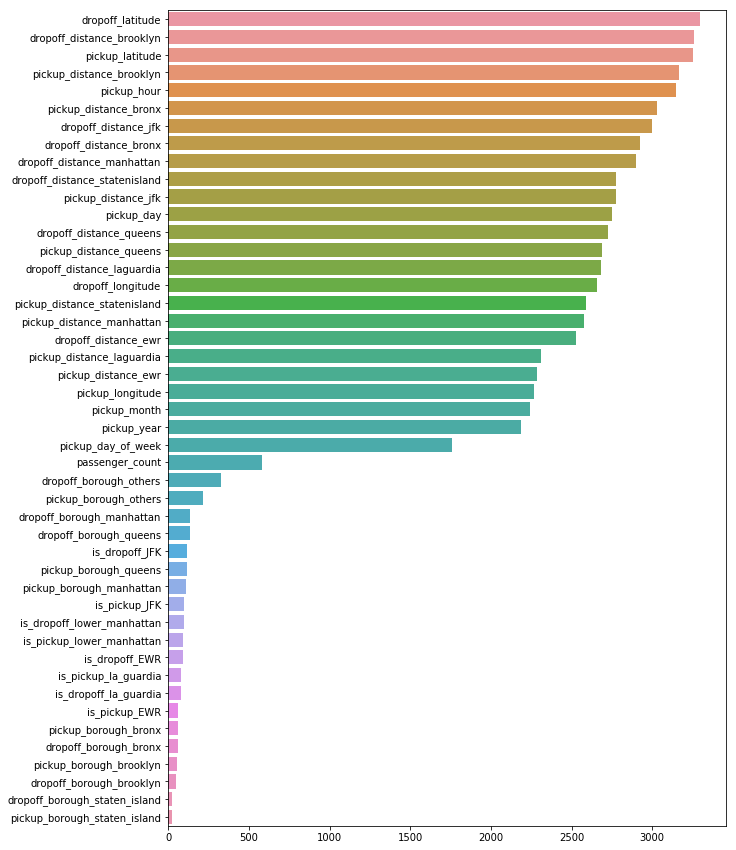

In [46]:
lgbm_feature_importance=sorted(zip(map(lambda x: round(x, 4),clf.feature_importances_), X_train.columns),reverse=True)
plt.figure(figsize=(10,15))
sns.barplot([imp for imp,feature in lgbm_feature_importance],[feature for imp,feature in lgbm_feature_importance])

#Training score

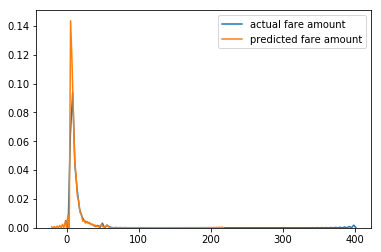

In [50]:
sns.kdeplot(y_test,label='actual fare amount')
sns.kdeplot(valid_pred,label='predicted fare amount')